In [5]:
from copy import copy

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from numpy.random import default_rng
from scipy.stats import norm, truncnorm

# ベイズモデルライブラリ
import pymc as pm
import cmdstanpy
cmdstanpy.install_cmdstan(compiler=True)  # only valid on Windows



%config InlineBackend.figure_format = 'retina'
rng = default_rng(12345)
az.style.use("arviz-darkgrid")

ModuleNotFoundError: No module named 'pymc'

## Censored Regression (切り捨て回帰)

以下の式を実装する

$$y_i^\ast = intercept + slope \times x_i + \epsilon \quad \epsilon \sim N(0, \sigma)$$

ただし、事前分布は以下のように設定される。
- $intercept \sim N(0, 1)$
- $slope \sim N(0, 1)$
- $sigma \sim HalfNorm(0, 1)$

$$
y_i =
    \begin{cases}
        c_l        &   \text{$y_i^\ast > c_l$のとき} \\
        c_u        &   \text{$y_i^\ast < c_u$のとき} \\
        y_i^\ast   &   \text{その他}
    \end{cases}
$$

In [2]:
# シミュレーションパラメータ
slope, intercept, sigma, N = 1, 0, 2, 200
x = rng.uniform(-10, 10, N)
y = rng.normal(loc=slope * x + intercept, scale=sigma)

def censor_y(x, y, bounds):
    cy = copy(y)
    cy[y <= bounds[0]] = bounds[0]
    cy[y >= bounds[1]] = bounds[1]
    return (x, cy)

bounds = [-5, 5]
xt, yt = censor_y(x, y, bounds)

[Text(0.5, 1.0, 'censored data')]

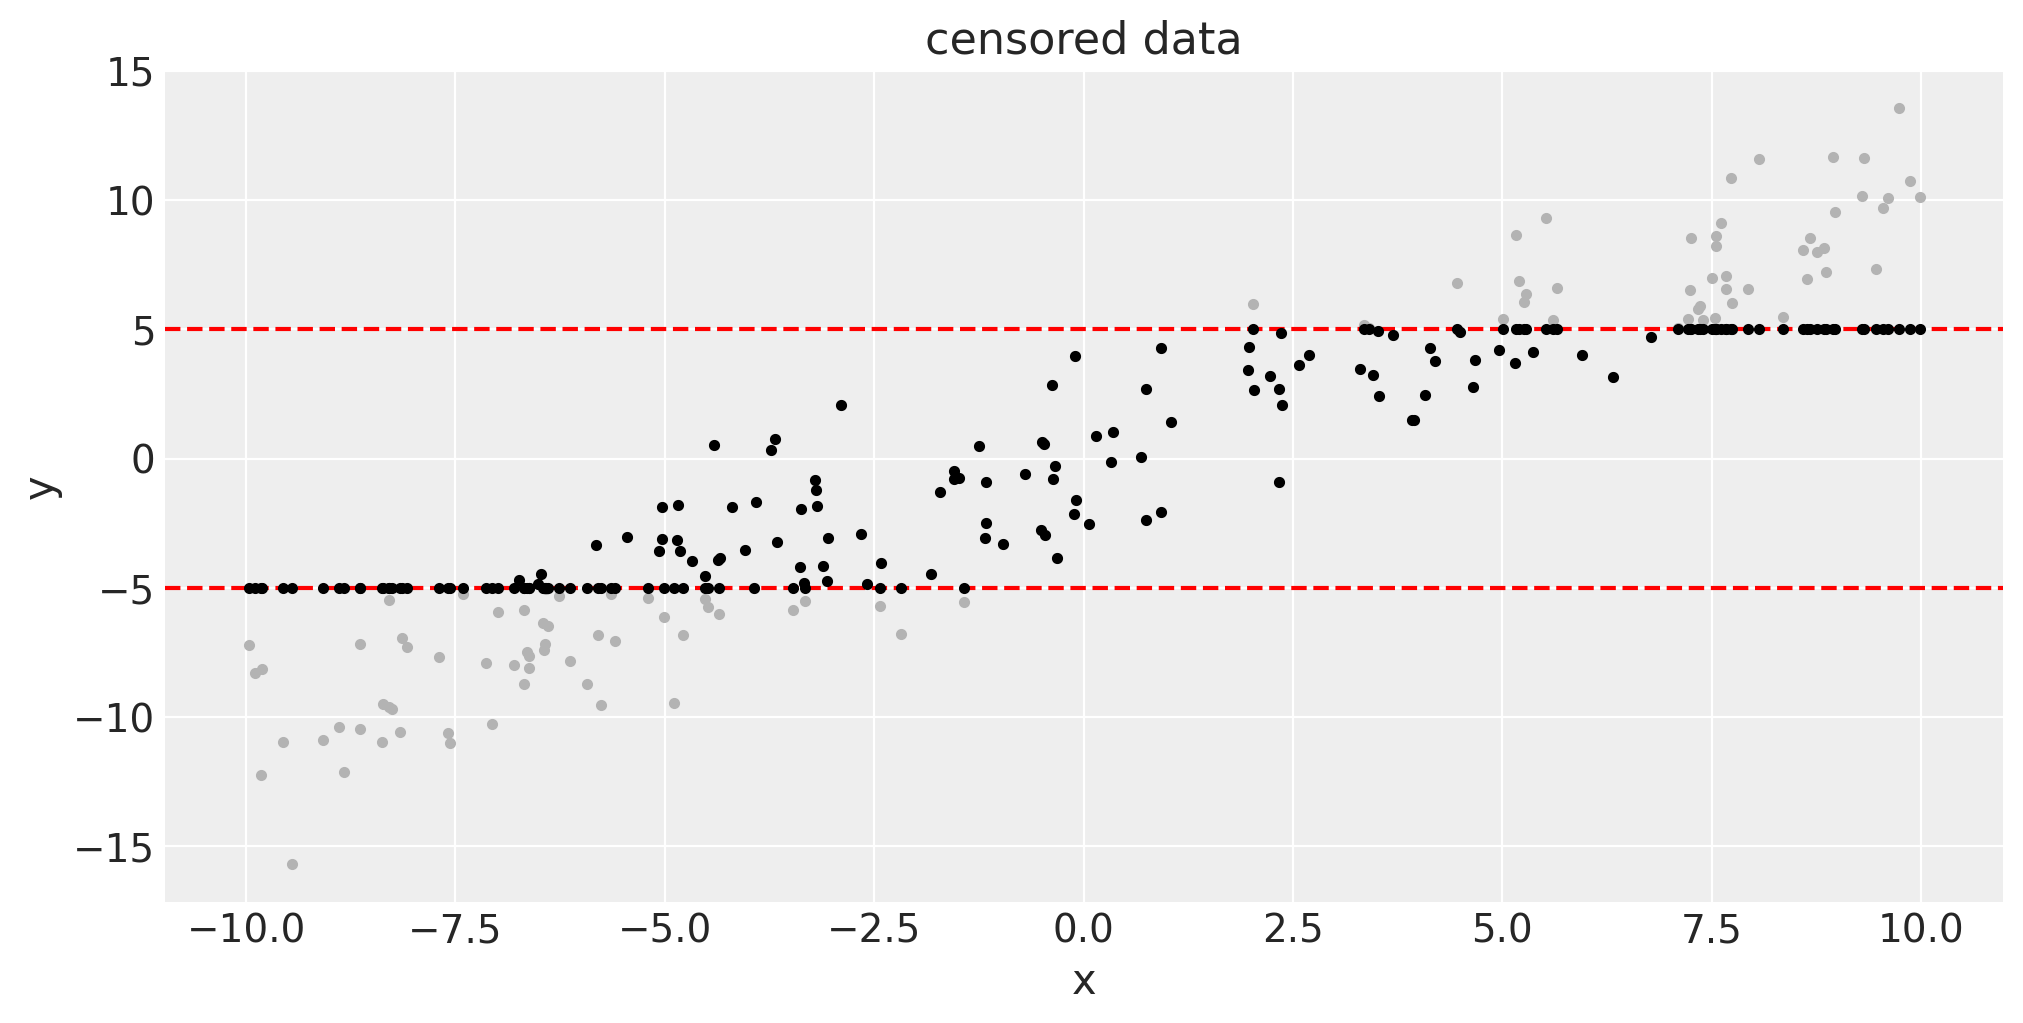

In [6]:
# プロット
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(x, y, ".", c=[0.7, 0.7, 0.7])
ax.axhline(bounds[0], c="r", ls="--")
ax.axhline(bounds[1], c="r", ls="--")
ax.set(xlabel="x", ylabel="y")
ax.plot(xt, yt, ".", c=[0, 0, 0])
ax.set(title="censored data")

In [3]:
def censored_regression(x, y, bounds):
    with pm.Model() as model:
        
        # 回帰係数
        slope = pm.Normal("slope", mu=0, sigma=1)
        
        # 切片項
        intercept = pm.Normal("intercept", mu=0, sigma=1)
        
        # 誤差分散
        sigma = pm.HalfNormal("sigma", sigma=1)
        
        # モデル式
        y_latent = pm.Normal.dist(mu=slope * x + intercept, sigma=sigma)
        
        # 切り捨ての実装
        obs = pm.Censored("obs", y_latent, lower=bounds[0], upper=bounds[1], observed=y)
    return model

In [4]:
# インスタンス化
censored_model = censored_regression(xt, yt, bounds)

# サンプリング
with censored_model:
    censored_fit = pm.sample()

AttributeError: module 'pymc3' has no attribute 'Censored'

In [ ]:
# 比較用の線形回帰モデル
def linear_regression(x, y):
    with pm.Model() as model:
        slope = pm.Normal("slope", mu=0, sigma=1)
        intercept = pm.Normal("intercept", mu=0, sigma=1)
        sigma = pm.HalfNormal("sigma", sd=1)
        y = pm.Normal("y", mu=slope * x + intercept, sigma=sigma, observed=y)
    return model

# インスタンス化
normal_linear_model = linear_regression(xt, yt)

# サンプリング
with normal_linear_model:
    linear_fit = pm.sample()

c:\Users\akihi\anaconda3\envs\baysian\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
c:\Users\akihi\anaconda3\envs\baysian\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
c:\Users\akihi\anaconda3\envs\baysian\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
c:\Users\akihi\anaconda3\envs\baysian\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (

: 

: 

In [ ]:
# 結果比較
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True)
az.plot_posterior(censored_fit, var_names=["slope"], ref_val=slope, ax=ax[0])
ax[0].set(title="censored regression\n(censored data)", xlabel="slope")
az.plot_posterior(linear_fit, var_names=["slope"], ref_val=slope, ax=ax[1])
ax[1].set(title="Linear regression\n(censored data)", xlabel="slope")

: 

# Pytanによる実装

: 